<a href="https://colab.research.google.com/github/ujjwalbb30/CMSC_678_ASL_image_classification_ML/blob/main/python_notebooks/Part_3_2_CNN_Mish_ASL_Image_Classification_Ujjwal_PF10610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifiying American Sign Language (ASL) images using Covolutional Neural Network (CNN) models**
# **Activation Function : 'mish'**

In this notebook, I will be training 10 different CNN models to classify ASL images. I will mainly use 'mish' activation function in the hidden layers. I will be conducting following experiments in this notebook:

▶ 5 different CNN models (with 1 Convolutional layer, 1 MaxPooling layer and 1 Dropout Layer) will be trained with following kernel sizes:

>(a) (4,4)

>(b) (5,5)

>(c) (6,6)

>(d) (7,7)

>(e) (8,8)

▶ For each kernel size mentioned above, 1 more type of CNN (models having the following characteristics), will be trained:

>(a) 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers

▶ In total, 10 models will be trained and following metrics will be calculated for each model along with Confusion matrix:

> (a) Accuracy

> (b) Precision

> (c) Recall

> (d) F1-score

## **Importing required libraries and data**

In [ ]:
# installing split-folders library to split the images dataset folders into training, validation and testing folders
!pip install split-folders

###**Importing required libraries**

In [ ]:
# importing required dependencies

# importing pandas, numpy, random, matplotlib and their required modules
import pandas as pd
import numpy as np
import random
from numpy.random import seed
seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# importing tensorflow, keras and their required modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam

# importing sklearn and their required modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# importing other required libraries
import glob
import cv2
import skimage
from skimage.transform import resize
import os
import gc

import splitfolders

###**Mounting the drive and copying the data to allocated machine**

In [ ]:
# mounting the drive to access data files
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# defining the path of data in drive (path to copy the data from)
# defining the path where the data should be copied
drive_path = '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset'
local_path = '/content'

# copying the data from drive to machine
!cp -av '/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset' '/content'

Streaming output truncated to the last 5000 lines.
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1898.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1898.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1904.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1904.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1890.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1890.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1880.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1880.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1908.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1908.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1888.jpg' -> '/content/dataset/asl_alphabet_train/Y/Y1888.jpg'
'/content/gdrive/MyDrive/CMSC_678/ML_Project/dataset/asl_alphabet_train/Y/Y1876.jpg' -> '/content/dataset/asl_alphabet_tr

###**Defining the mish activation function**

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import tensorflow_addons as tfa
def mish(x):
    return tfa.activations.mish(x)

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

###**Splitting the images dataset folder into train, validation and test images**
###**creating train, validation and test dataframes of image paths and labels**

In [ ]:
# splitting the folder intro training, validation and test dataset
splitfolders.ratio("/content/dataset/asl_alphabet_train", output="/content/dataset/split_dataset", seed=42, ratio=(.7, .1, .2), group_prefix=None)

Copying files: 87020 files [00:11, 7275.44 files/s]


In [ ]:
# Exploring the new created split dataset folder
dataset_folder_path = '/content/dataset/split_dataset'
for path, directories, files in os.walk(dataset_folder_path):
    print(path,'--> number of files : ', len(files))

/content/dataset/split_dataset --> number of files :  0
/content/dataset/split_dataset/val --> number of files :  0
/content/dataset/split_dataset/val/L --> number of files :  300
/content/dataset/split_dataset/val/J --> number of files :  300
/content/dataset/split_dataset/val/P --> number of files :  300
/content/dataset/split_dataset/val/space --> number of files :  300
/content/dataset/split_dataset/val/D --> number of files :  300
/content/dataset/split_dataset/val/C --> number of files :  300
/content/dataset/split_dataset/val/N --> number of files :  301
/content/dataset/split_dataset/val/T --> number of files :  300
/content/dataset/split_dataset/val/V --> number of files :  300
/content/dataset/split_dataset/val/M --> number of files :  300
/content/dataset/split_dataset/val/Z --> number of files :  300
/content/dataset/split_dataset/val/U --> number of files :  300
/content/dataset/split_dataset/val/del --> number of files :  300
/content/dataset/split_dataset/val/B --> numbe

In [ ]:
# Preparing train, validation and test dataframes of image paths and labels

# defining the path to train, validation and test images data folders
train_dataset_folder = '/content/dataset/split_dataset/train'
validation_dataset_folder = '/content/dataset/split_dataset/val'
test_dataset_folder = '/content/dataset/split_dataset/test'

# initializing empty lists to store paths and labels of train, validation and test images
train_data = []
val_data = []
test_data = []

# saving train images paths and labels
for folder in os.listdir(train_dataset_folder):
    label_folder = os.path.join(train_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    train_data += onlyfiles

# saving validation images paths and labels
for folder in os.listdir(validation_dataset_folder):
    label_folder = os.path.join(validation_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    val_data += onlyfiles

# saving test images paths and labels
for folder in os.listdir(test_dataset_folder):
    label_folder = os.path.join(test_dataset_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    test_data += onlyfiles

# creating dataframes from the lists
train_data_df = pd.DataFrame(train_data)
val_data_df = pd.DataFrame(val_data)
test_data_df = pd.DataFrame(test_data)

# viewing the details of training dataframe
print('training data:\n')
display(train_data_df)
print('\nunique labels:\n',train_data_df['label'].unique())
print('\n number of unique labels:\n',train_data_df['label'].nunique())

# viewing the details of validation dataframe
print('\nvalidation data:\n')
display(val_data_df)
print('\nunique labels:\n',val_data_df['label'].unique())
print('\n number of unique labels:\n',val_data_df['label'].nunique())

# viewing the details of testing dataframe
print('\ntesting data:\n')
display(test_data_df)
print('\nunique labels:\n',test_data_df['label'].unique())
print('\n number of unique labels:\n',test_data_df['label'].nunique())

training data:



label                                              path
0         L  /content/dataset/split_dataset/train/L/L1931.jpg
1         L   /content/dataset/split_dataset/train/L/L745.jpg
2         L  /content/dataset/split_dataset/train/L/L2826.jpg
3         L  /content/dataset/split_dataset/train/L/L2334.jpg
4         L  /content/dataset/split_dataset/train/L/L2813.jpg
...     ...                                               ...
60909     A   /content/dataset/split_dataset/train/A/A337.jpg
60910     A  /content/dataset/split_dataset/train/A/A2414.jpg
60911     A  /content/dataset/split_dataset/train/A/A1004.jpg
60912     A  /content/dataset/split_dataset/train/A/A1055.jpg
60913     A   /content/dataset/split_dataset/train/A/A447.jpg

[60914 rows x 2 columns]


unique labels:
 ['L' 'J' 'P' 'space' 'D' 'C' 'N' 'T' 'V' 'M' 'Z' 'U' 'del' 'B' 'S'
 'nothing' 'W' 'R' 'E' 'Y' 'I' 'X' 'O' 'F' 'G' 'Q' 'K' 'H' 'A']

 number of unique labels:
 29

validation data:



label                                            path
0        L  /content/dataset/split_dataset/val/L/L2612.jpg
1        L  /content/dataset/split_dataset/val/L/L1419.jpg
2        L  /content/dataset/split_dataset/val/L/L2622.jpg
3        L  /content/dataset/split_dataset/val/L/L1788.jpg
4        L    /content/dataset/split_dataset/val/L/L44.jpg
...    ...                                             ...
8697     A   /content/dataset/split_dataset/val/A/A816.jpg
8698     A   /content/dataset/split_dataset/val/A/A378.jpg
8699     A  /content/dataset/split_dataset/val/A/A1465.jpg
8700     A  /content/dataset/split_dataset/val/A/A1601.jpg
8701     A  /content/dataset/split_dataset/val/A/A1093.jpg

[8702 rows x 2 columns]


unique labels:
 ['L' 'J' 'P' 'space' 'D' 'C' 'N' 'T' 'V' 'M' 'Z' 'U' 'del' 'B' 'S'
 'nothing' 'W' 'R' 'E' 'Y' 'I' 'X' 'O' 'F' 'G' 'Q' 'K' 'H' 'A']

 number of unique labels:
 29

testing data:



label                                             path
0         L   /content/dataset/split_dataset/test/L/L126.jpg
1         L  /content/dataset/split_dataset/test/L/L1183.jpg
2         L  /content/dataset/split_dataset/test/L/L2844.jpg
3         L   /content/dataset/split_dataset/test/L/L324.jpg
4         L  /content/dataset/split_dataset/test/L/L1585.jpg
...     ...                                              ...
17399     A  /content/dataset/split_dataset/test/A/A2818.jpg
17400     A  /content/dataset/split_dataset/test/A/A1544.jpg
17401     A  /content/dataset/split_dataset/test/A/A2065.jpg
17402     A   /content/dataset/split_dataset/test/A/A202.jpg
17403     A  /content/dataset/split_dataset/test/A/A1130.jpg

[17404 rows x 2 columns]


unique labels:
 ['L' 'J' 'P' 'space' 'D' 'C' 'N' 'T' 'V' 'M' 'Z' 'U' 'del' 'B' 'S'
 'nothing' 'W' 'R' 'E' 'Y' 'I' 'X' 'O' 'F' 'G' 'Q' 'K' 'H' 'A']

 number of unique labels:
 29


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


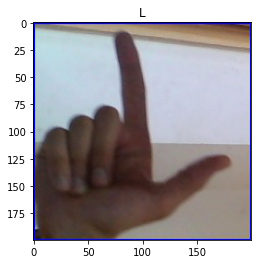

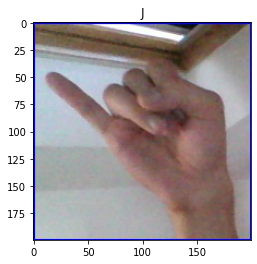

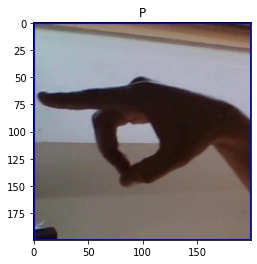

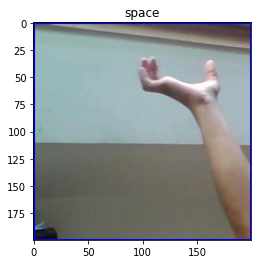

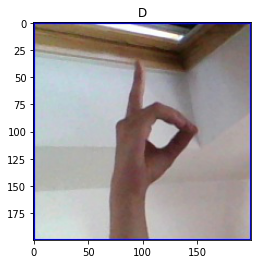

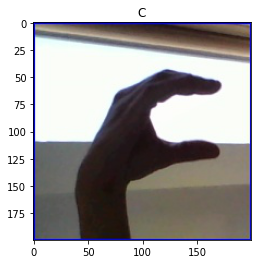

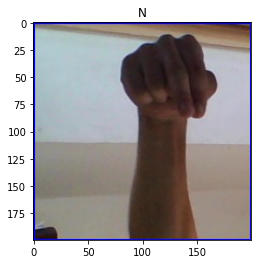

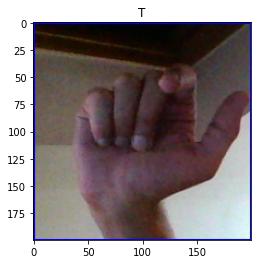

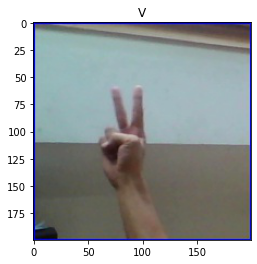

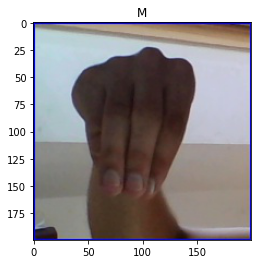

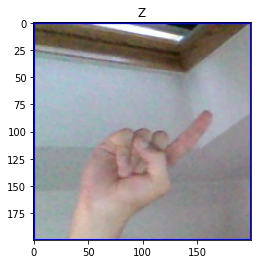

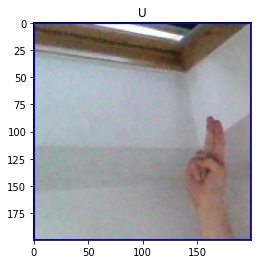

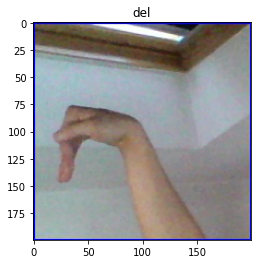

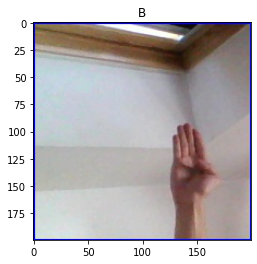

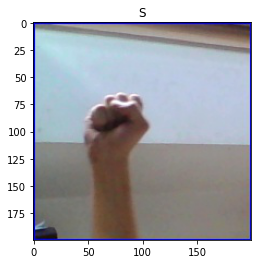

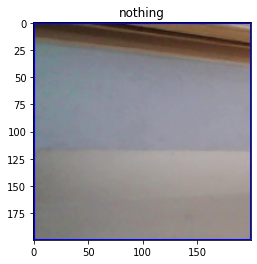

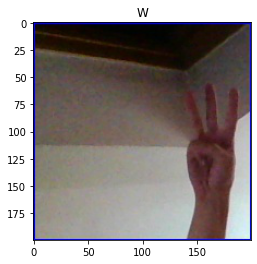

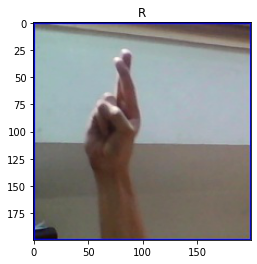

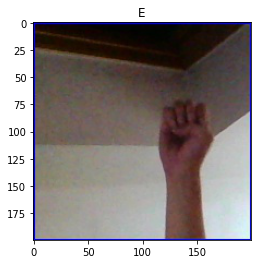

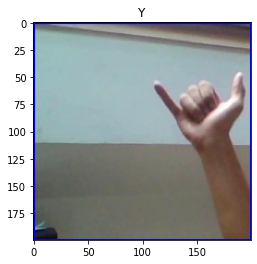

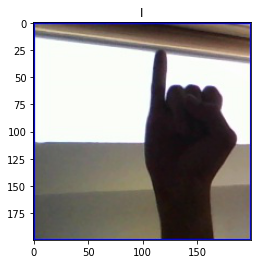

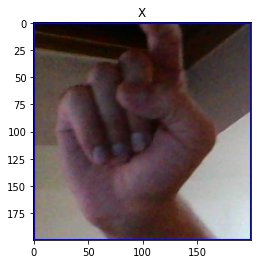

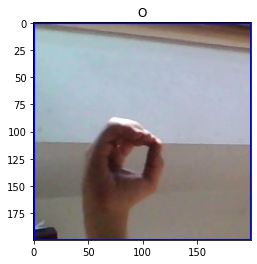

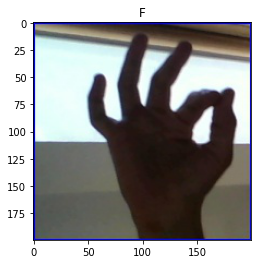

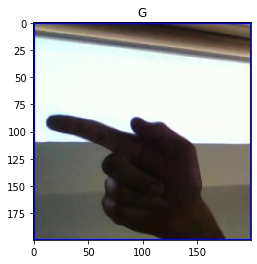

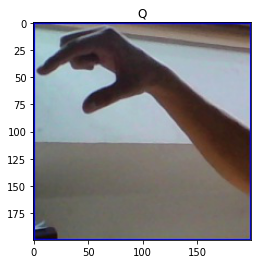

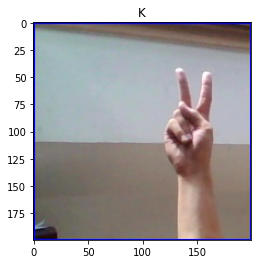

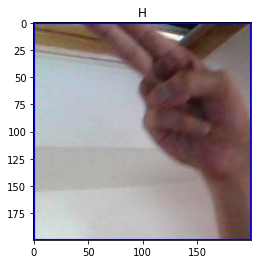

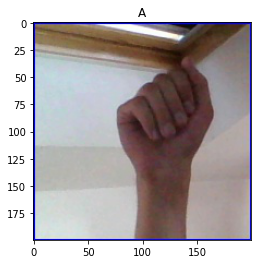

In [ ]:
# viewing random images of each label from train dataframe

unique_asl_signs = train_data_df['label'].unique().tolist()
images = []

for sign in unique_asl_signs:
    rows = train_data_df[train_data_df['label']==sign]['path']
    random_pick = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[random_pick]
    img = mpimg.imread(filepath)
    plt.figure()
    plt.title(sign)
    plt.imshow(img)

In [ ]:
# viewing number of images in train dataset, validation dataset and test dataset
print(f'training data size: {len(train_data_df)}')
print(f'validation data size: {len(val_data_df)}')
print(f'testing data size: {len(test_data_df)}')

training data size: 60914
validation data size: 8702
testing data size: 17404


###**Creating image data generators for train, validation and test image dataset to feed the images to training models in batches**

In [ ]:
# creating image data generators

# defining image dimensions, batch size, target size of image, target dimensions and number of labels
img_dim = 64
batch_size = 64
target_size = (img_dim, img_dim)
target_dims = (img_dim, img_dim, 3)
num_classes = len(train_data_df['label'].unique())

# images are normalized, but not augmented

# train image generator
train_datagen = ImageDataGenerator(rescale = 1/255.0,horizontal_flip=True, vertical_flip=True,brightness_range=[0.2,1.0])
train_generator = train_datagen.flow_from_dataframe(dataframe=train_data_df,x_col='path', y_col='label', target_size=(img_dim, img_dim),class_mode='categorical', batch_size=batch_size, shuffle=False)

# validation image generator
validation_datagen = ImageDataGenerator(rescale = 1/255.0,horizontal_flip=True, vertical_flip=True,brightness_range=[0.2,1.0])
validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)

# testing image generator
test_datagen = ImageDataGenerator(rescale = 1/255.0,horizontal_flip=True, vertical_flip=True,brightness_range=[0.2,1.0])
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data_df, x_col='path', y_col='label', target_size=(img_dim, img_dim), class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 60914 validated image filenames belonging to 29 classes.
Found 8702 validated image filenames belonging to 29 classes.
Found 17404 validated image filenames belonging to 29 classes.


## **CNN Models with 1 Convolutional layer, 1 Maxpooling layer and 1 Dropout layer**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_1l = Sequential()

model_1_1l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_1l.add(Activation('relu'))
model_1_1l.add(MaxPooling2D((2, 2)))
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Flatten())
model_1_1l.add(Dropout(0.5))

model_1_1l.add(Dense(128, activation='mish'))

model_1_1l.add(Dense(num_classes, activation='softmax'))

model_1_1l.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation_1 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 28800)             0         
                                                        

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 96s 100ms/step - loss: 3.2597 - accuracy: 0.0851 - val_loss: 2.9117 - val_accuracy: 0.1533
Epoch 2/10
952/952 [==============================] - 94s 98ms/step - loss: 2.5892 - accuracy: 0.2372 - val_loss: 2.1116 - val_accuracy: 0.3606
Epoch 3/10
952/952 [==============================] - 95s 100ms/step - loss: 2.0600 - accuracy: 0.3628 - val_loss: 1.7614 - val_accuracy: 0.4554
Epoch 4/10
952/952 [==============================] - 104s 109ms/step - loss: 1.7121 - accuracy: 0.4559 - val_loss: 1.3164 - val_accuracy: 0.6158
Epoch 5/10
952/952 [==============================] - 107s 113ms/step - loss: 1.4492 - accuracy: 0.5342 - val_loss: 1.1794 - val_accuracy: 0.6178
Epoch 6/10
952/952 [==============================] - 108s 113ms/step - loss: 1.2629 - accuracy: 0.5889 - val_loss: 0.9563 - val_accuracy: 0.6952
Epoch 7/10
952/952 [==============================] - 105s 111ms/step - loss: 1.1186 - accuracy: 0.6324 - val_loss: 0.8628 - val

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.259688  0.085087  2.911685      0.153298
1  2.589210  0.237203  2.111630      0.360607
2  2.060048  0.362757  1.761442      0.455413
3  1.712146  0.455938  1.316376      0.615835
4  1.449229  0.534196  1.179367      0.617789
5  1.262852  0.588863  0.956269      0.695242
6  1.118586  0.632433  0.862791      0.728683
7  1.013379  0.664018  0.809915      0.727994
8  0.926417  0.693666  0.696743      0.773385
9  0.857025  0.712726  0.613393      0.791083

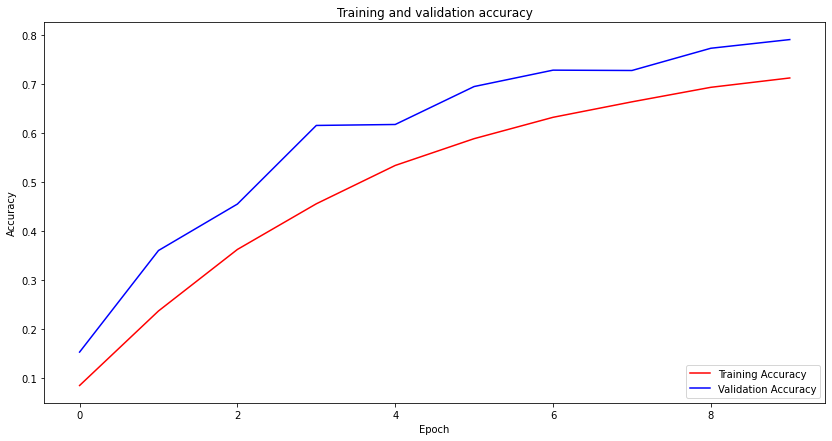

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_1l.history.history['accuracy']
val_acc= model_1_1l.history.history['val_accuracy']
loss= model_1_1l.history.history['loss']
val_loss= model_1_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

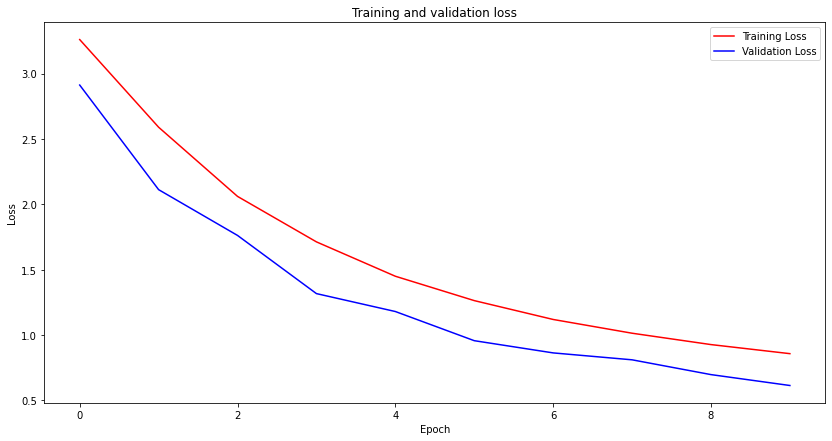

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 22s 82ms/step - loss: 0.6175 - accuracy: 0.7878
loss : 0.6175298690795898 acc : 0.7878074049949646


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 22s 82ms/step
              precision    recall  f1-score   support

           A       0.79      0.88      0.84       600
           B       0.91      0.88      0.90       600
           C       0.97      0.97      0.97       600
           D       0.96      0.86      0.91       600
           E       0.82      0.67      0.74       600
           F       0.95      0.91      0.93       600
           G       0.74      0.96      0.83       600
           H       0.93      0.79      0.85       600
           I       0.66      0.99      0.79       602
           J       0.93      0.93      0.93       600
           K       0.92      0.86      0.89       600
           L       0.89      0.96      0.93       600
           M       0.89      0.72      0.79       600
           N       0.94      0.69      0.80       602
           O       0.98      0.58      0.73       600
           P       0.83      0.87      0.85       600
           Q       0.86 

<Figure size 3600x3600 with 0 Axes>

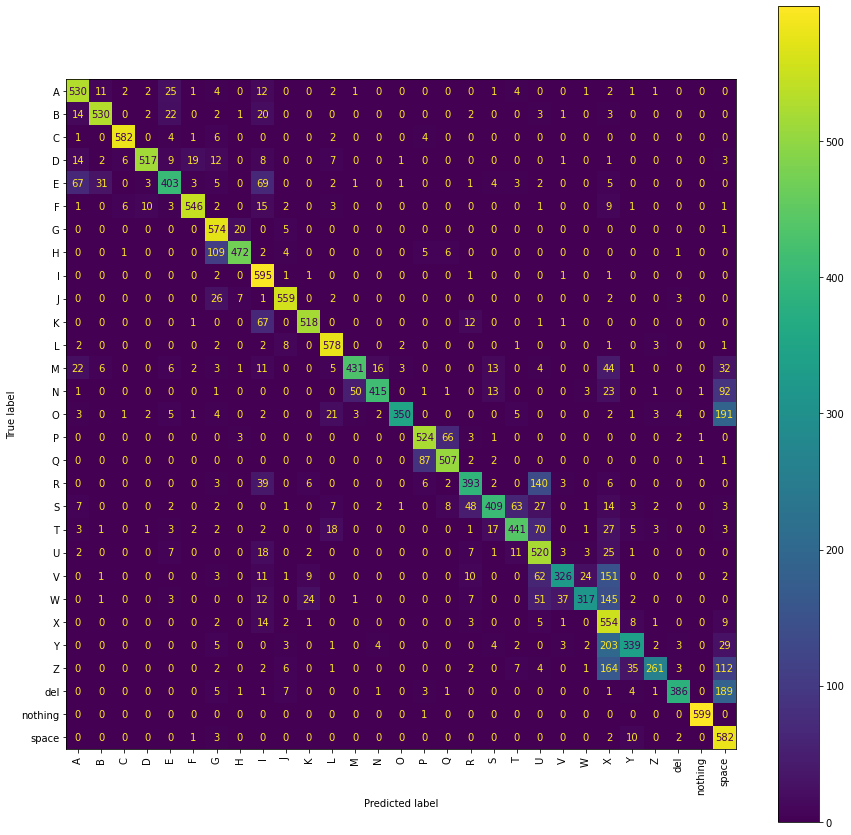

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_1l = Sequential()

model_2_1l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_1l.add(Activation('relu'))
model_2_1l.add(MaxPooling2D((2, 2)))
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Flatten())
model_2_1l.add(Dropout(0.5))

model_2_1l.add(Dense(128, activation='mish'))

model_2_1l.add(Dense(num_classes, activation='softmax'))

model_2_1l.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_2 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_3 (Dropout)         (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 98s 103ms/step - loss: 3.3982 - accuracy: 0.0423 - val_loss: 3.3341 - val_accuracy: 0.0500
Epoch 2/10
952/952 [==============================] - 99s 104ms/step - loss: 3.2623 - accuracy: 0.0852 - val_loss: 3.0290 - val_accuracy: 0.1417
Epoch 3/10
952/952 [==============================] - 108s 114ms/step - loss: 2.8265 - accuracy: 0.1830 - val_loss: 2.4401 - val_accuracy: 0.2725
Epoch 4/10
952/952 [==============================] - 109s 115ms/step - loss: 2.3166 - accuracy: 0.2998 - val_loss: 1.8584 - val_accuracy: 0.4424
Epoch 5/10
952/952 [==============================] - 110s 115ms/step - loss: 1.9543 - accuracy: 0.3980 - val_loss: 1.5463 - val_accuracy: 0.5421
Epoch 6/10
952/952 [==============================] - 110s 116ms/step - loss: 1.7003 - accuracy: 0.4707 - val_loss: 1.3490 - val_accuracy: 0.5870
Epoch 7/10
952/952 [==============================] - 109s 114ms/step - loss: 1.5156 - accuracy: 0.5230 - val_loss: 1.1645 - v

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.398165  0.042273  3.334063      0.049989
1  3.262301  0.085169  3.029026      0.141692
2  2.826477  0.183029  2.440123      0.272466
3  2.316561  0.299767  1.858439      0.442427
4  1.954298  0.398020  1.546275      0.542059
5  1.700262  0.470664  1.349012      0.586991
6  1.515602  0.522967  1.164460      0.639049
7  1.393870  0.559970  1.051821      0.680074
8  1.281531  0.593689  0.930725      0.711331
9  1.186155  0.619743  0.823153      0.746840

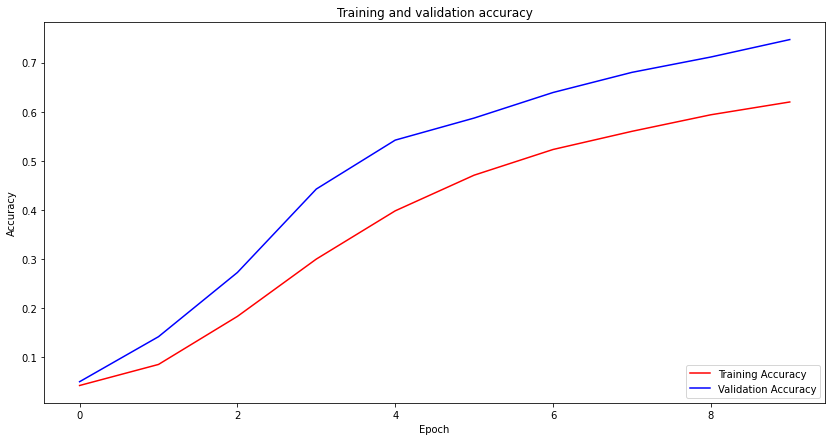

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_1l.history.history['accuracy']
val_acc= model_2_1l.history.history['val_accuracy']
loss= model_2_1l.history.history['loss']
val_loss= model_2_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

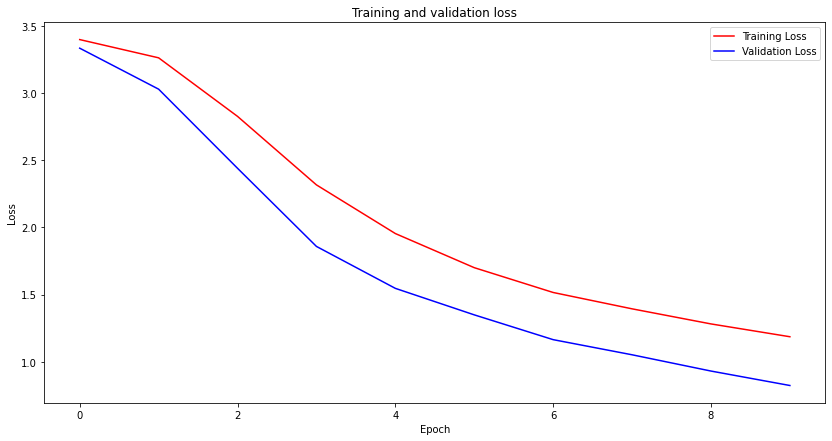

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 22s 81ms/step - loss: 0.8376 - accuracy: 0.7440
loss : 0.8376102447509766 acc : 0.7440243363380432


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 22s 82ms/step
              precision    recall  f1-score   support

           A       0.63      0.84      0.72       600
           B       0.87      0.79      0.83       600
           C       0.96      0.97      0.97       600
           D       0.75      0.90      0.82       600
           E       0.91      0.54      0.68       600
           F       0.86      0.91      0.88       600
           G       0.88      0.90      0.89       600
           H       0.91      0.90      0.91       600
           I       0.83      0.88      0.85       602
           J       0.90      0.91      0.91       600
           K       0.90      0.84      0.87       600
           L       0.87      0.89      0.88       600
           M       0.91      0.52      0.66       600
           N       0.77      0.80      0.78       602
           O       0.96      0.52      0.67       600
           P       0.92      0.57      0.71       600
           Q       0.67 

<Figure size 3600x3600 with 0 Axes>

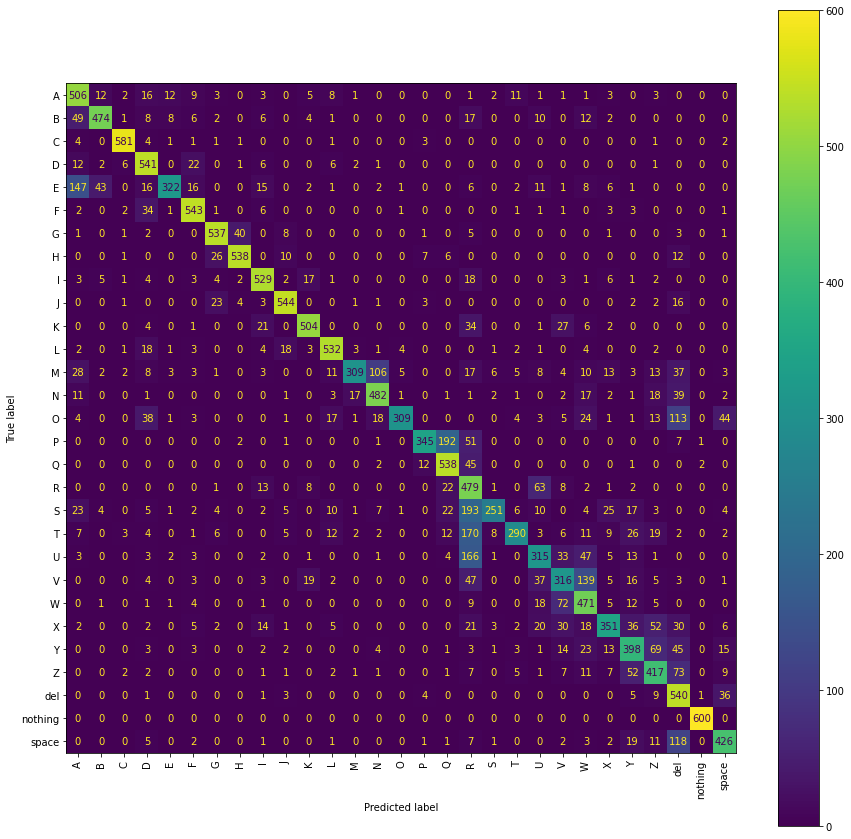

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_1l = Sequential()

model_3_1l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_1l.add(Activation('relu'))
model_3_1l.add(MaxPooling2D((2, 2)))
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Flatten())
model_3_1l.add(Dropout(0.5))

model_3_1l.add(Dense(128, activation='mish'))

model_3_1l.add(Dense(num_classes, activation='softmax'))

model_3_1l.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_3 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 28800)             0         
                                                                 
 dropout_5 (Dropout)         (None, 28800)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 95s 100ms/step - loss: 3.2793 - accuracy: 0.0884 - val_loss: 2.8429 - val_accuracy: 0.2287
Epoch 2/10
952/952 [==============================] - 106s 111ms/step - loss: 2.6646 - accuracy: 0.2238 - val_loss: 2.2135 - val_accuracy: 0.3590
Epoch 3/10
952/952 [==============================] - 107s 112ms/step - loss: 2.1522 - accuracy: 0.3354 - val_loss: 1.8439 - val_accuracy: 0.4261
Epoch 4/10
952/952 [==============================] - 106s 111ms/step - loss: 1.7918 - accuracy: 0.4349 - val_loss: 1.3995 - val_accuracy: 0.5683
Epoch 5/10
952/952 [==============================] - 106s 112ms/step - loss: 1.5194 - accuracy: 0.5118 - val_loss: 1.2469 - val_accuracy: 0.6363
Epoch 6/10
952/952 [==============================] - 107s 112ms/step - loss: 1.3145 - accuracy: 0.5732 - val_loss: 0.9721 - val_accuracy: 0.6985
Epoch 7/10
952/952 [==============================] - 107s 113ms/step - loss: 1.1513 - accuracy: 0.6234 - val_loss: 0.8414 - 

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.279275  0.088436  2.842924      0.228683
1  2.664570  0.223807  2.213536      0.358998
2  2.152215  0.335374  1.843906      0.426109
3  1.791826  0.434859  1.399529      0.568260
4  1.519437  0.511754  1.246907      0.636290
5  1.314483  0.573152  0.972082      0.698460
6  1.151318  0.623371  0.841350      0.741898
7  1.020329  0.665348  0.782885      0.750402
8  0.940402  0.690432  0.635913      0.812572
9  0.858203  0.717388  0.551784      0.828775

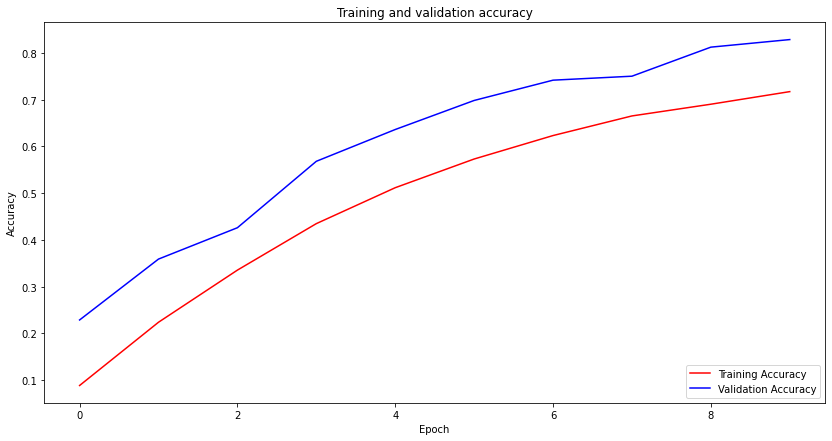

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_1l.history.history['accuracy']
val_acc= model_3_1l.history.history['val_accuracy']
loss= model_3_1l.history.history['loss']
val_loss= model_3_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

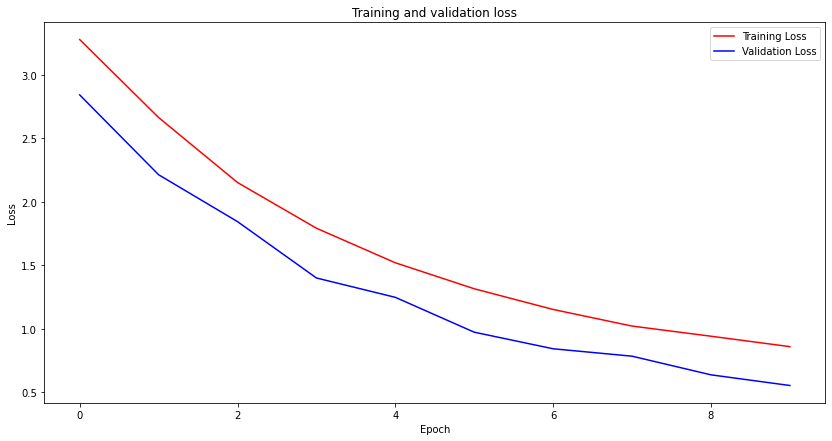

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 22s 81ms/step - loss: 0.5609 - accuracy: 0.8244
loss : 0.5608711838722229 acc : 0.8244081735610962


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 22s 81ms/step
              precision    recall  f1-score   support

           A       0.73      0.91      0.81       600
           B       0.85      0.94      0.89       600
           C       0.98      0.94      0.96       600
           D       0.87      0.96      0.91       600
           E       0.90      0.61      0.73       600
           F       0.92      0.96      0.94       600
           G       0.92      0.84      0.88       600
           H       0.83      0.97      0.89       600
           I       0.93      0.90      0.92       602
           J       1.00      0.85      0.92       600
           K       0.92      0.94      0.93       600
           L       0.96      0.94      0.95       600
           M       0.90      0.66      0.76       600
           N       0.84      0.89      0.86       602
           O       0.68      0.95      0.80       600
           P       0.92      0.82      0.87       600
           Q       0.84 

<Figure size 3600x3600 with 0 Axes>

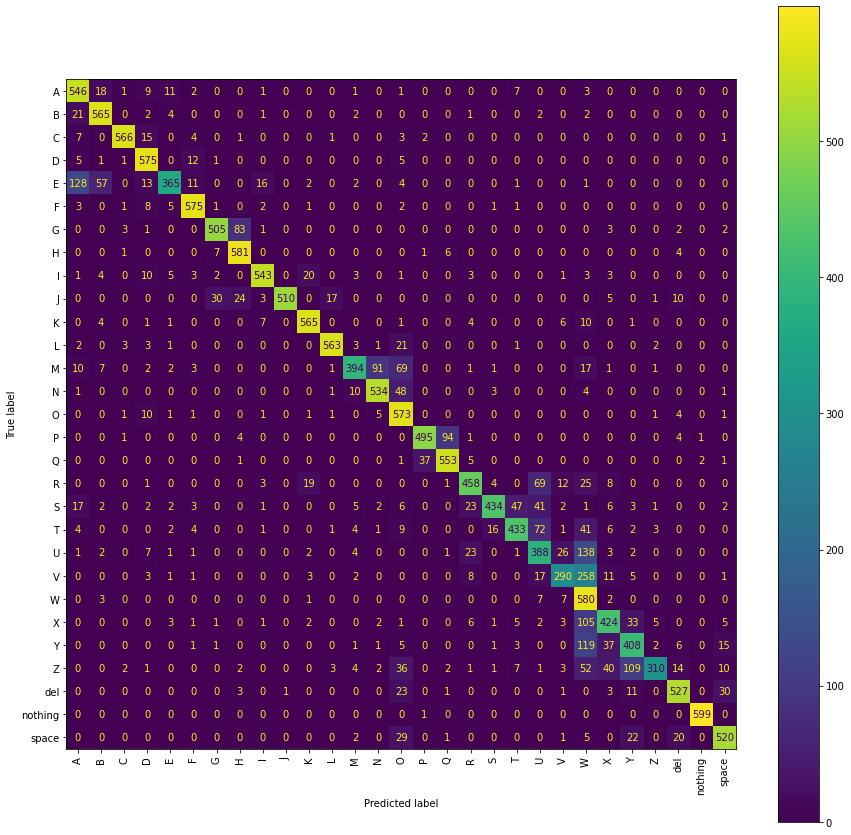

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_1l = Sequential()

model_4_1l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_1l.add(Activation('relu'))
model_4_1l.add(MaxPooling2D((2, 2)))
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Flatten())
model_4_1l.add(Dropout(0.5))

model_4_1l.add(Dense(128, activation='mish'))

model_4_1l.add(Dense(num_classes, activation='softmax'))

model_4_1l.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 59, 59, 32)        3488      
                                                                 
 activation_4 (Activation)   (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 26912)             0         
                                                                 
 dropout_7 (Dropout)         (None, 26912)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 98s 102ms/step - loss: 3.3185 - accuracy: 0.0726 - val_loss: 3.0694 - val_accuracy: 0.1454
Epoch 2/10
952/952 [==============================] - 108s 113ms/step - loss: 2.9010 - accuracy: 0.1695 - val_loss: 2.4638 - val_accuracy: 0.2564
Epoch 3/10
952/952 [==============================] - 109s 114ms/step - loss: 2.4398 - accuracy: 0.2678 - val_loss: 2.0107 - val_accuracy: 0.4157
Epoch 4/10
952/952 [==============================] - 109s 115ms/step - loss: 2.0579 - accuracy: 0.3664 - val_loss: 1.6251 - val_accuracy: 0.5017
Epoch 5/10
952/952 [==============================] - 110s 116ms/step - loss: 1.7743 - accuracy: 0.4461 - val_loss: 1.4911 - val_accuracy: 0.5319
Epoch 6/10
952/952 [==============================] - 111s 116ms/step - loss: 1.5646 - accuracy: 0.5052 - val_loss: 1.1805 - val_accuracy: 0.6480
Epoch 7/10
952/952 [==============================] - 110s 116ms/step - loss: 1.3833 - accuracy: 0.5585 - val_loss: 1.0420 - 

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.318545  0.072643  3.069433      0.145369
1  2.901031  0.169518  2.463832      0.256378
2  2.439822  0.267837  2.010740      0.415652
3  2.057930  0.366385  1.625081      0.501724
4  1.774318  0.446088  1.491105      0.531947
5  1.564645  0.505155  1.180493      0.648012
6  1.383252  0.558509  1.042029      0.691105
7  1.248715  0.600486  0.925817      0.710641
8  1.144102  0.630249  0.792144      0.770742
9  1.058834  0.657008  0.762704      0.770398

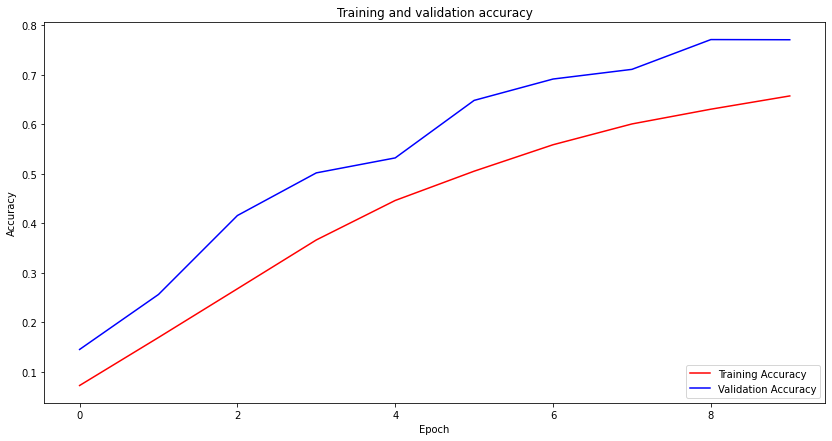

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_1l.history.history['accuracy']
val_acc= model_4_1l.history.history['val_accuracy']
loss= model_4_1l.history.history['loss']
val_loss= model_4_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

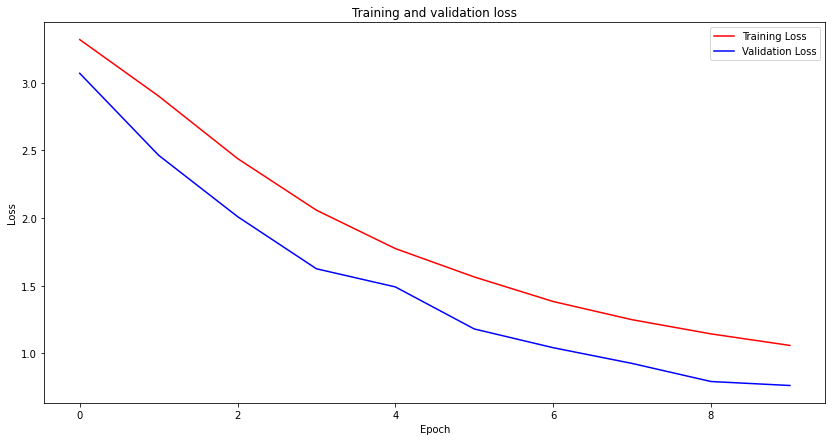

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 23s 83ms/step - loss: 0.7590 - accuracy: 0.7704
loss : 0.7590184807777405 acc : 0.7703976035118103


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 23s 83ms/step
              precision    recall  f1-score   support

           A       0.64      0.86      0.73       600
           B       0.67      0.94      0.78       600
           C       0.99      0.93      0.96       600
           D       0.87      0.91      0.89       600
           E       0.98      0.33      0.49       600
           F       0.75      0.95      0.84       600
           G       0.91      0.84      0.87       600
           H       0.85      0.95      0.89       600
           I       0.91      0.84      0.88       602
           J       0.90      0.93      0.91       600
           K       0.78      0.90      0.84       600
           L       0.94      0.93      0.93       600
           M       0.92      0.45      0.61       600
           N       0.62      0.93      0.74       602
           O       0.77      0.76      0.76       600
           P       0.95      0.74      0.83       600
           Q       0.81 

<Figure size 3600x3600 with 0 Axes>

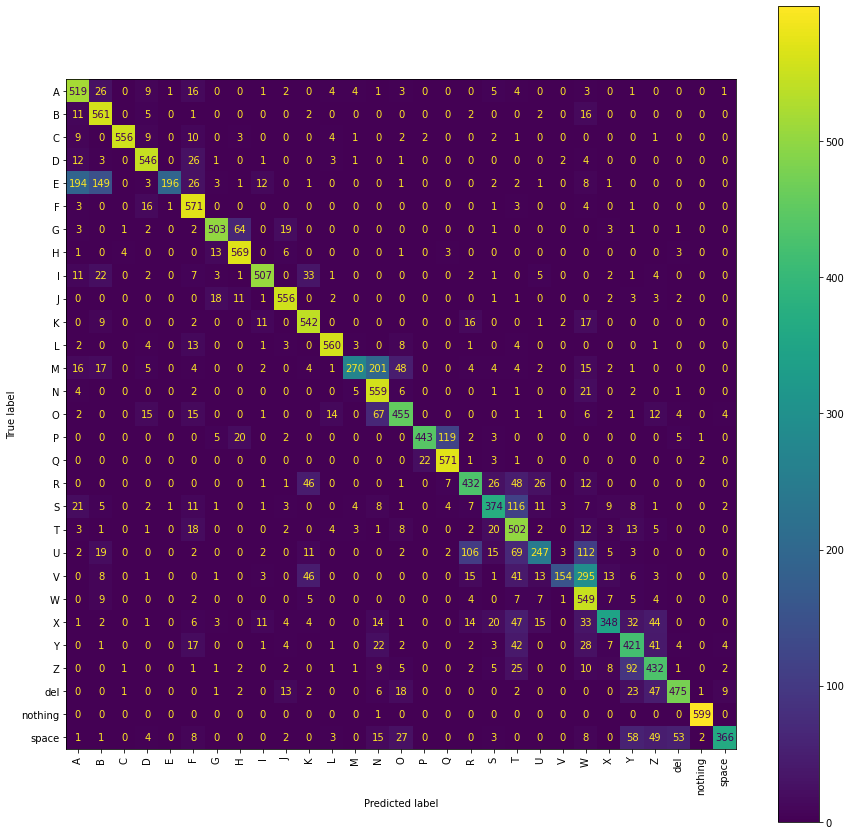

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_1l = Sequential()

model_5_1l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_1l.add(Activation('relu'))
model_5_1l.add(MaxPooling2D((2, 2)))
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Flatten())
model_5_1l.add(Dropout(0.5))

model_5_1l.add(Dense(128, activation='mish'))

model_5_1l.add(Dense(num_classes, activation='softmax'))

model_5_1l.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 57, 57, 32)        6176      
                                                                 
 activation_5 (Activation)   (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_9 (Dropout)         (None, 25088)             0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_1l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_1l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 99s 104ms/step - loss: 3.3928 - accuracy: 0.0291 - val_loss: 3.3664 - val_accuracy: 0.0362
Epoch 2/10
952/952 [==============================] - 107s 113ms/step - loss: 3.3399 - accuracy: 0.0493 - val_loss: 3.2026 - val_accuracy: 0.1043
Epoch 3/10
952/952 [==============================] - 109s 114ms/step - loss: 3.0682 - accuracy: 0.1332 - val_loss: 2.7010 - val_accuracy: 0.2211
Epoch 4/10
952/952 [==============================] - 109s 115ms/step - loss: 2.6236 - accuracy: 0.2228 - val_loss: 2.1868 - val_accuracy: 0.3564
Epoch 5/10
952/952 [==============================] - 108s 114ms/step - loss: 2.2782 - accuracy: 0.3109 - val_loss: 1.9757 - val_accuracy: 0.3883
Epoch 6/10
952/952 [==============================] - 109s 115ms/step - loss: 2.0053 - accuracy: 0.3836 - val_loss: 1.6609 - val_accuracy: 0.4784
Epoch 7/10
952/952 [==============================] - 110s 115ms/step - loss: 1.8061 - accuracy: 0.4416 - val_loss: 1.5089 - 

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_1l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.392761  0.029057  3.366365      0.036199
1  3.339929  0.049283  3.202636      0.104344
2  3.068164  0.133204  2.701036      0.221099
3  2.623627  0.222806  2.186755      0.356355
4  2.278159  0.310897  1.975735      0.388302
5  2.005290  0.383623  1.660882      0.478396
6  1.806117  0.441623  1.508911      0.531947
7  1.653595  0.482631  1.359231      0.579982
8  1.540583  0.520077  1.171011      0.650770
9  1.430342  0.552238  1.149653      0.645024

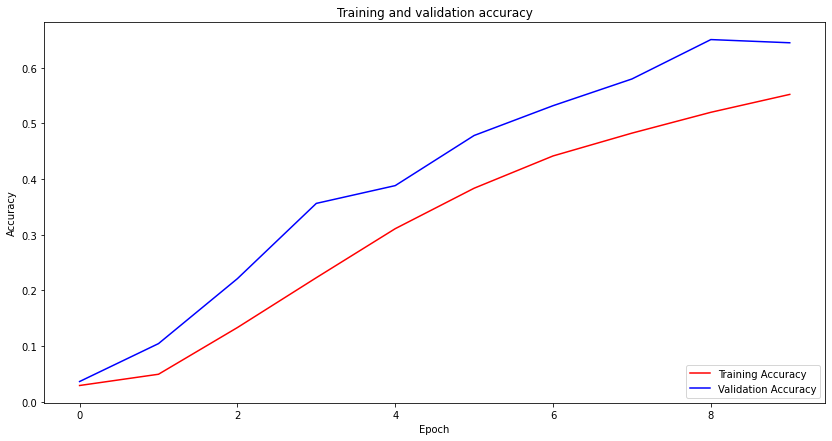

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_1l.history.history['accuracy']
val_acc= model_5_1l.history.history['val_accuracy']
loss= model_5_1l.history.history['loss']
val_loss= model_5_1l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

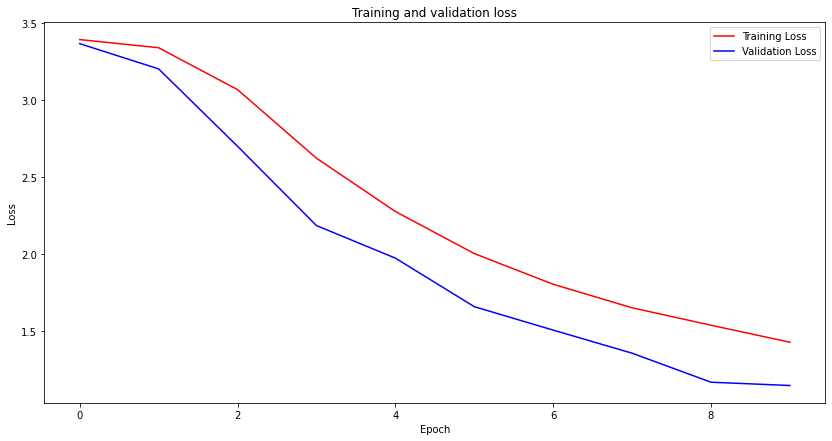

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_1l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 23s 83ms/step - loss: 1.1599 - accuracy: 0.6413
loss : 1.1599448919296265 acc : 0.6412893533706665


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_1l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 23s 83ms/step
              precision    recall  f1-score   support

           A       0.92      0.49      0.64       600
           B       0.45      0.92      0.61       600
           C       0.98      0.95      0.96       600
           D       0.73      0.87      0.79       600
           E       0.61      0.49      0.54       600
           F       0.82      0.81      0.81       600
           G       0.77      0.84      0.80       600
           H       0.89      0.78      0.83       600
           I       0.78      0.68      0.73       602
           J       0.82      0.86      0.84       600
           K       0.66      0.78      0.72       600
           L       0.92      0.73      0.81       600
           M       0.58      0.57      0.58       600
           N       0.76      0.71      0.73       602
           O       0.92      0.45      0.61       600
           P       0.75      0.64      0.69       600
           Q       0.66 

<Figure size 3600x3600 with 0 Axes>

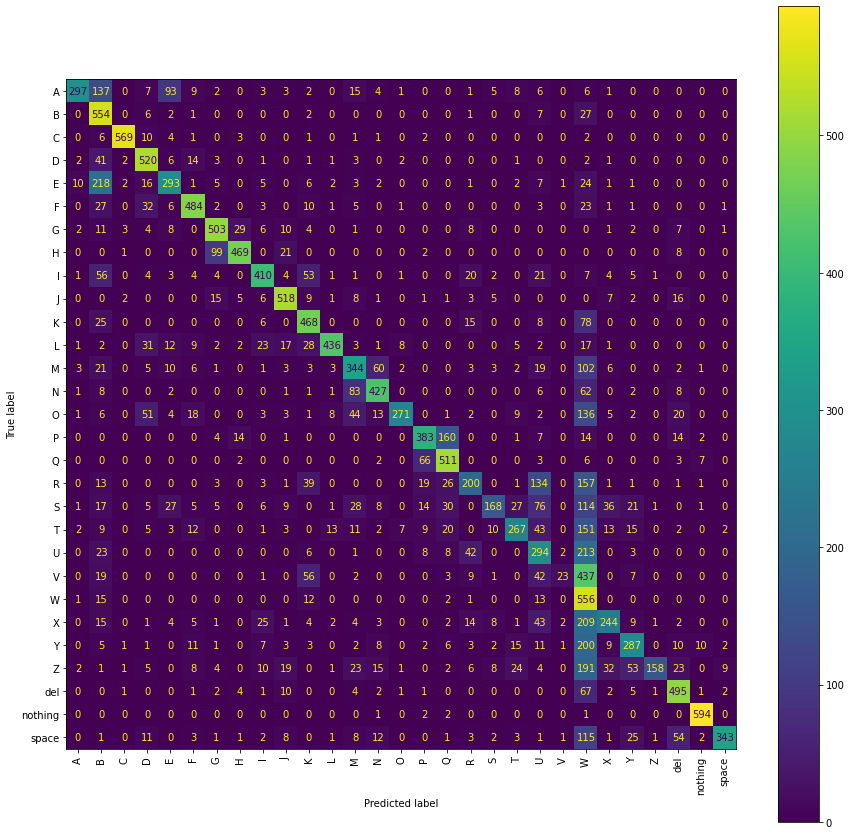

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

## **CNN Models with 2 Convolutional layers, 2 Maxpooling layers and 2 Dropout layers**

#### **Kernel size - (5,5)**

In [ ]:
# defining the model
model_1_2l = Sequential()

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Conv2D(32, kernel_size=(5,5), input_shape=target_dims))
model_1_2l.add(Activation('relu'))
model_1_2l.add(MaxPooling2D((2, 2)))
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Flatten())
model_1_2l.add(Dropout(0.5))

model_1_2l.add(Dense(128, activation='mish'))

model_1_2l.add(Dense(num_classes, activation='softmax'))

model_1_2l.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 activation_6 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        25632     
                                                                 
 activation_7 (Activation)   (None, 26, 26, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_1_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_1_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 121s 127ms/step - loss: 3.3781 - accuracy: 0.0228 - val_loss: 3.3676 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 122s 128ms/step - loss: 3.3630 - accuracy: 0.0329 - val_loss: 3.2977 - val_accuracy: 0.0816
Epoch 3/10
952/952 [==============================] - 122s 128ms/step - loss: 3.2092 - accuracy: 0.0943 - val_loss: 2.9687 - val_accuracy: 0.1710
Epoch 4/10
952/952 [==============================] - 121s 127ms/step - loss: 2.8574 - accuracy: 0.1695 - val_loss: 2.5268 - val_accuracy: 0.2591
Epoch 5/10
952/952 [==============================] - 121s 127ms/step - loss: 2.4452 - accuracy: 0.2634 - val_loss: 1.9917 - val_accuracy: 0.3955
Epoch 6/10
952/952 [==============================] - 120s 127ms/step - loss: 2.0940 - accuracy: 0.3539 - val_loss: 1.6418 - val_accuracy: 0.5234
Epoch 7/10
952/952 [==============================] - 130s 137ms/step - loss: 1.8329 - accuracy: 0.4243 - val_loss: 1.3994 -

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_1_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.378129  0.022786  3.367560      0.034475
1  3.362958  0.032915  3.297671      0.081590
2  3.209248  0.094313  2.968740      0.170995
3  2.857388  0.169534  2.526820      0.259136
4  2.445205  0.263421  1.991656      0.395541
5  2.093956  0.353942  1.641799      0.523443
6  1.832868  0.424270  1.399360      0.555619
7  1.624634  0.482040  1.209282      0.642956
8  1.456973  0.529599  1.123500      0.680763
9  1.339519  0.564681  0.984195      0.686854

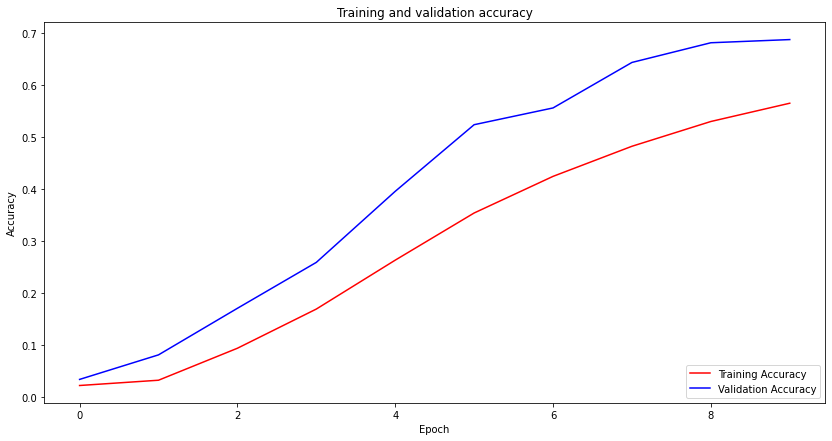

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_1_2l.history.history['accuracy']
val_acc= model_1_2l.history.history['val_accuracy']
loss= model_1_2l.history.history['loss']
val_loss= model_1_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

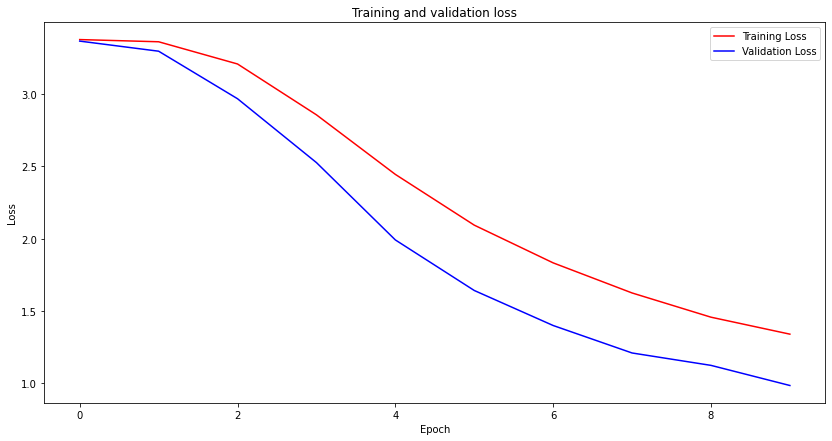

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_1_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 25s 90ms/step - loss: 0.9859 - accuracy: 0.6843
loss : 0.9858570098876953 acc : 0.6843254566192627


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_1_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 25s 90ms/step
              precision    recall  f1-score   support

           A       0.91      0.49      0.64       600
           B       0.74      0.82      0.78       600
           C       0.98      0.95      0.96       600
           D       0.95      0.81      0.88       600
           E       0.63      0.70      0.67       600
           F       0.88      0.91      0.89       600
           G       0.99      0.47      0.64       600
           H       0.67      0.96      0.79       600
           I       0.88      0.73      0.80       602
           J       0.87      0.87      0.87       600
           K       0.68      0.82      0.74       600
           L       0.83      0.93      0.87       600
           M       0.77      0.47      0.59       600
           N       0.94      0.49      0.64       602
           O       0.66      0.89      0.75       600
           P       0.94      0.46      0.62       600
           Q       0.62 

<Figure size 3600x3600 with 0 Axes>

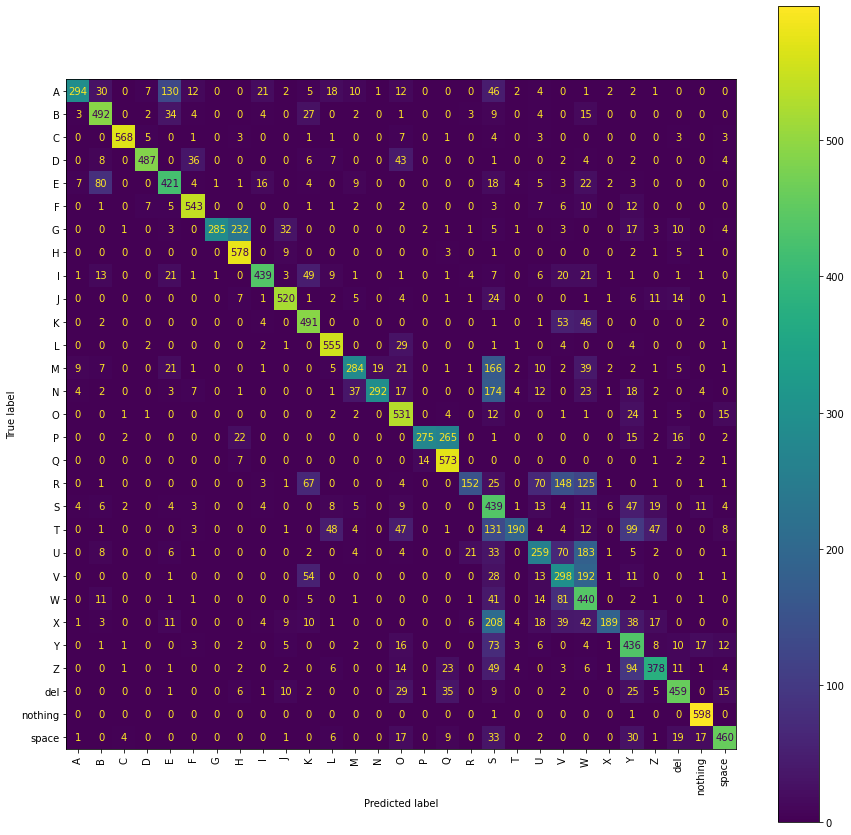

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (7,7)**

In [ ]:
# defining the model
model_2_2l = Sequential()

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Conv2D(32, kernel_size=(7,7), input_shape=target_dims))
model_2_2l.add(Activation('relu'))
model_2_2l.add(MaxPooling2D((2, 2)))
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Flatten())
model_2_2l.add(Dropout(0.5))

model_2_2l.add(Dense(128, activation='mish'))

model_2_2l.add(Dense(num_classes, activation='softmax'))

model_2_2l.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 58, 58, 32)        4736      
                                                                 
 activation_8 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 23, 32)        50208     
                                                                 
 activation_9 (Activation)   (None, 23, 23, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_2_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_2_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 116s 121ms/step - loss: 3.3779 - accuracy: 0.0225 - val_loss: 3.3675 - val_accuracy: 0.0346
Epoch 2/10
952/952 [==============================] - 123s 129ms/step - loss: 3.3725 - accuracy: 0.0259 - val_loss: 3.3678 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 122s 128ms/step - loss: 3.3668 - accuracy: 0.0281 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 123s 129ms/step - loss: 3.3736 - accuracy: 0.0138 - val_loss: 3.3676 - val_accuracy: 0.0345
Epoch 5/10
952/952 [==============================] - 123s 129ms/step - loss: 3.3726 - accuracy: 0.0246 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 125s 131ms/step - loss: 3.3728 - accuracy: 0.0247 - val_loss: 3.3678 - val_accuracy: 0.0345
Epoch 7/10
952/952 [==============================] - 126s 132ms/step - loss: 3.3733 - accuracy: 0.0189 - val_loss: 3.3675 -

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_2_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.377870  0.022540  3.367533      0.034590
1  3.372514  0.025922  3.367825      0.034475
2  3.366809  0.028105  3.367672      0.034475
3  3.373602  0.013839  3.367613      0.034475
4  3.372622  0.024625  3.367656      0.034475
5  3.372805  0.024674  3.367805      0.034475
6  3.373259  0.018879  3.367457      0.034475
7  3.372466  0.023361  3.367848      0.034475
8  3.372163  0.025380  3.368746      0.034475
9  3.372674  0.022934  3.368054      0.034475

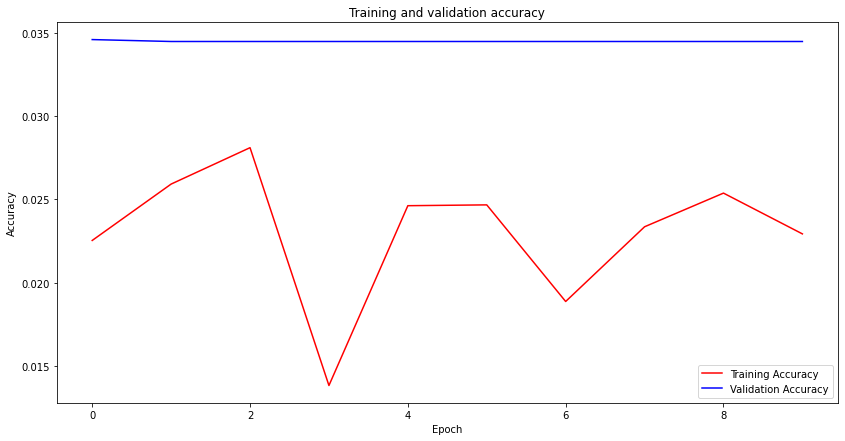

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_2_2l.history.history['accuracy']
val_acc= model_2_2l.history.history['val_accuracy']
loss= model_2_2l.history.history['loss']
val_loss= model_2_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

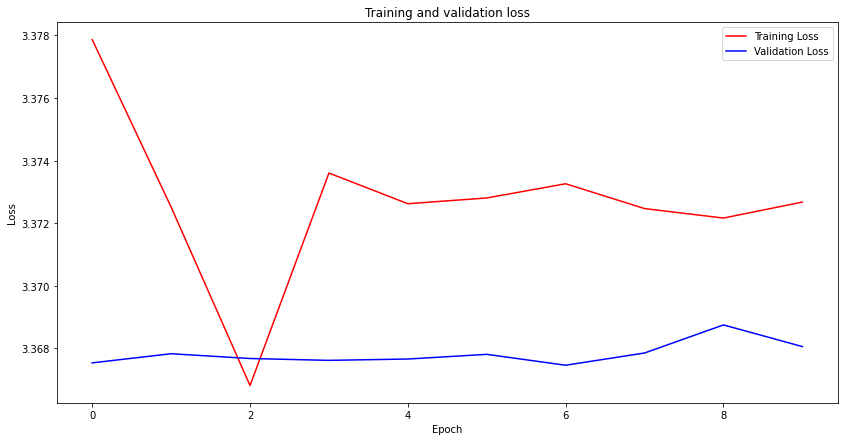

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_2_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 24s 88ms/step - loss: 3.3681 - accuracy: 0.0345
loss : 3.368053436279297 acc : 0.03447483479976654


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_2_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 24s 89ms/step
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.00      0.00      0.00       600
           H       0.00      0.00      0.00       600
           I       0.00      0.00      0.00       602
           J       0.00      0.00      0.00       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.00      0.00      0.00       602
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       600
           Q       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3600x3600 with 0 Axes>

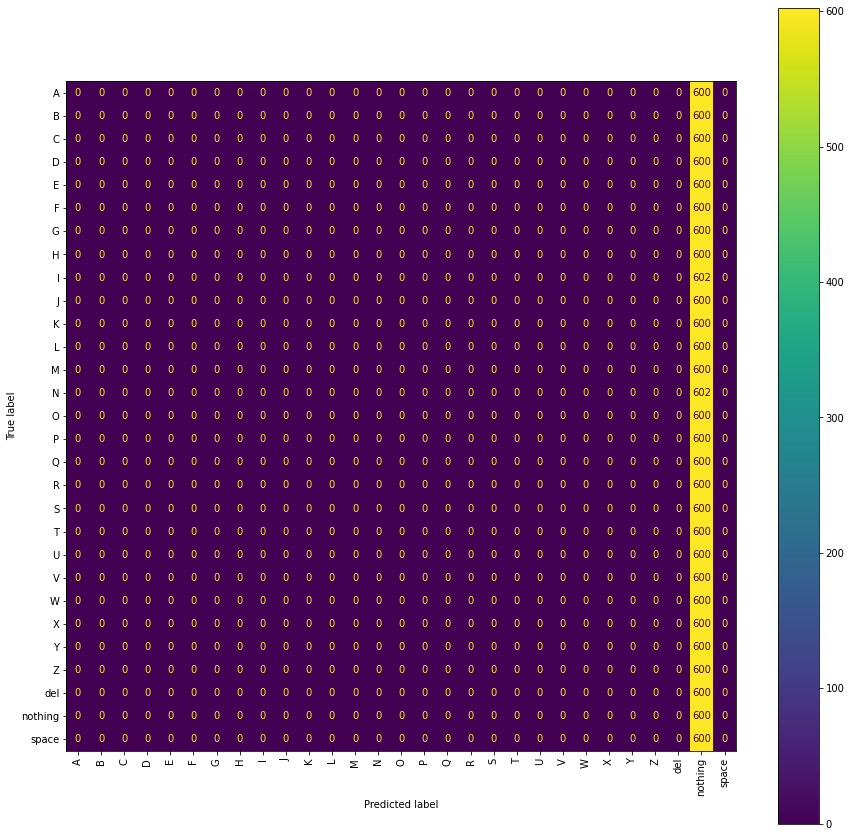

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (4,4)**

In [ ]:
# defining the model
model_3_2l = Sequential()

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Conv2D(32, kernel_size=(4,4), input_shape=target_dims))
model_3_2l.add(Activation('relu'))
model_3_2l.add(MaxPooling2D((2, 2)))
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Flatten())
model_3_2l.add(Dropout(0.5))

model_3_2l.add(Dense(128, activation='mish'))

model_3_2l.add(Dense(num_classes, activation='softmax'))

model_3_2l.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 61, 61, 32)        1568      
                                                                 
 activation_10 (Activation)  (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 32)        16416     
                                                                 
 activation_11 (Activation)  (None, 27, 27, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_3_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_3_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 115s 120ms/step - loss: 3.3809 - accuracy: 0.0236 - val_loss: 3.3658 - val_accuracy: 0.0403
Epoch 2/10
952/952 [==============================] - 117s 123ms/step - loss: 3.3296 - accuracy: 0.0611 - val_loss: 3.1887 - val_accuracy: 0.1145
Epoch 3/10
952/952 [==============================] - 117s 123ms/step - loss: 3.0127 - accuracy: 0.1446 - val_loss: 2.7266 - val_accuracy: 0.2179
Epoch 4/10
952/952 [==============================] - 117s 123ms/step - loss: 2.5640 - accuracy: 0.2417 - val_loss: 2.1599 - val_accuracy: 0.3369
Epoch 5/10
952/952 [==============================] - 118s 124ms/step - loss: 2.2115 - accuracy: 0.3304 - val_loss: 1.7728 - val_accuracy: 0.4802
Epoch 6/10
952/952 [==============================] - 121s 127ms/step - loss: 1.9231 - accuracy: 0.4097 - val_loss: 1.5765 - val_accuracy: 0.5344
Epoch 7/10
952/952 [==============================] - 118s 124ms/step - loss: 1.6849 - accuracy: 0.4771 - val_loss: 1.3279 -

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_3_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.380882  0.023574  3.365789      0.040336
1  3.329597  0.061070  3.188748      0.114456
2  3.012667  0.144647  2.726560      0.217881
3  2.564008  0.241734  2.159903      0.336934
4  2.211492  0.330367  1.772846      0.480234
5  1.923087  0.409725  1.576516      0.534360
6  1.684892  0.477066  1.327922      0.611239
7  1.481950  0.532850  1.066996      0.700069
8  1.354624  0.571281  0.940175      0.732820
9  1.235207  0.601651  0.823740      0.750862

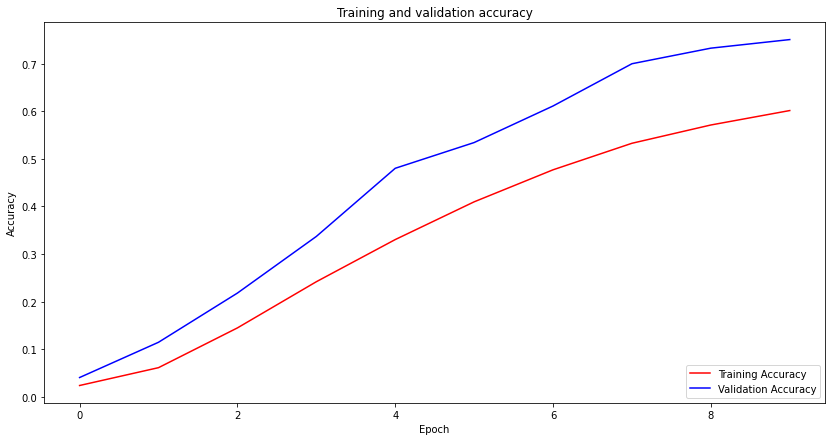

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_3_2l.history.history['accuracy']
val_acc= model_3_2l.history.history['val_accuracy']
loss= model_3_2l.history.history['loss']
val_loss= model_3_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

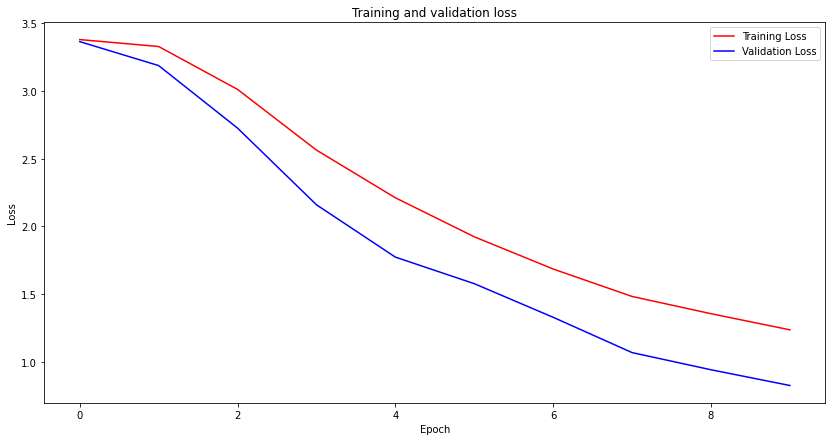

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_3_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 25s 91ms/step - loss: 0.8160 - accuracy: 0.7538
loss : 0.8159882426261902 acc : 0.7538496851921082


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_3_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 24s 89ms/step
              precision    recall  f1-score   support

           A       0.75      0.68      0.71       600
           B       0.64      0.86      0.73       600
           C       0.99      0.95      0.97       600
           D       0.86      0.94      0.89       600
           E       0.92      0.46      0.61       600
           F       0.88      0.92      0.90       600
           G       0.92      0.74      0.82       600
           H       0.81      0.94      0.87       600
           I       0.93      0.70      0.80       602
           J       0.88      0.89      0.89       600
           K       0.69      0.81      0.75       600
           L       0.98      0.80      0.88       600
           M       0.74      0.70      0.72       600
           N       0.87      0.73      0.79       602
           O       0.80      0.86      0.83       600
           P       0.96      0.64      0.77       600
           Q       0.72 

<Figure size 3600x3600 with 0 Axes>

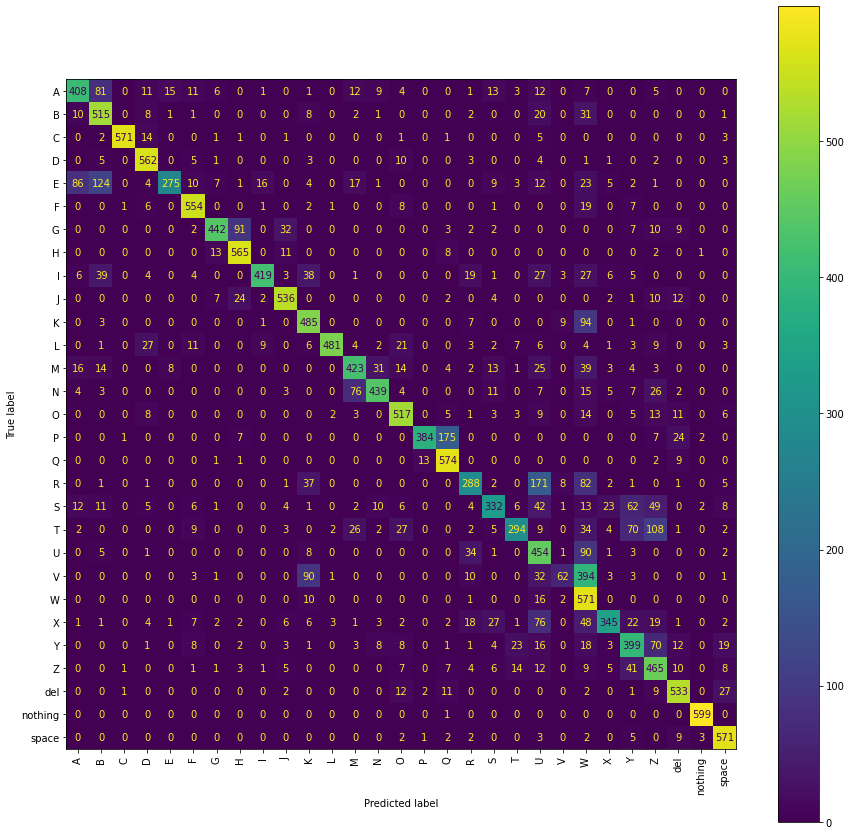

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (6,6)**

In [ ]:
# defining the model
model_4_2l = Sequential()

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Conv2D(32, kernel_size=(6,6), input_shape=target_dims))
model_4_2l.add(Activation('relu'))
model_4_2l.add(MaxPooling2D((2, 2)))
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Flatten())
model_4_2l.add(Dropout(0.5))

model_4_2l.add(Dense(128, activation='mish'))

model_4_2l.add(Dense(num_classes, activation='softmax'))

model_4_2l.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 59, 59, 32)        3488      
                                                                 
 activation_12 (Activation)  (None, 59, 59, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 32)        36896     
                                                                 
 activation_13 (Activation)  (None, 24, 24, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_4_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_4_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 122s 127ms/step - loss: 3.3764 - accuracy: 0.0297 - val_loss: 3.3678 - val_accuracy: 0.0345
Epoch 2/10
952/952 [==============================] - 128s 134ms/step - loss: 3.3736 - accuracy: 0.0336 - val_loss: 3.3678 - val_accuracy: 0.0345
Epoch 3/10
952/952 [==============================] - 128s 135ms/step - loss: 3.3741 - accuracy: 0.0241 - val_loss: 3.3681 - val_accuracy: 0.0345
Epoch 4/10
952/952 [==============================] - 127s 134ms/step - loss: 3.3730 - accuracy: 0.0328 - val_loss: 3.3679 - val_accuracy: 0.0345
Epoch 5/10
952/952 [==============================] - 128s 134ms/step - loss: 3.3732 - accuracy: 0.0243 - val_loss: 3.3682 - val_accuracy: 0.0345
Epoch 6/10
952/952 [==============================] - 127s 133ms/step - loss: 3.3727 - accuracy: 0.0281 - val_loss: 3.3677 - val_accuracy: 0.0345
Epoch 7/10
952/952 [==============================] - 127s 134ms/step - loss: 3.3729 - accuracy: 0.0261 - val_loss: 3.3678 -

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_4_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.376390  0.029698  3.367761      0.034475
1  3.373587  0.033556  3.367846      0.034475
2  3.374129  0.024083  3.368141      0.034475
3  3.373037  0.032751  3.367899      0.034475
4  3.373154  0.024264  3.368177      0.034475
5  3.372740  0.028105  3.367709      0.034475
6  3.372939  0.026119  3.367794      0.034475
7  3.372448  0.025364  3.367923      0.034475
8  3.374578  0.024395  3.367505      0.034475
9  3.373085  0.024411  3.367651      0.034475

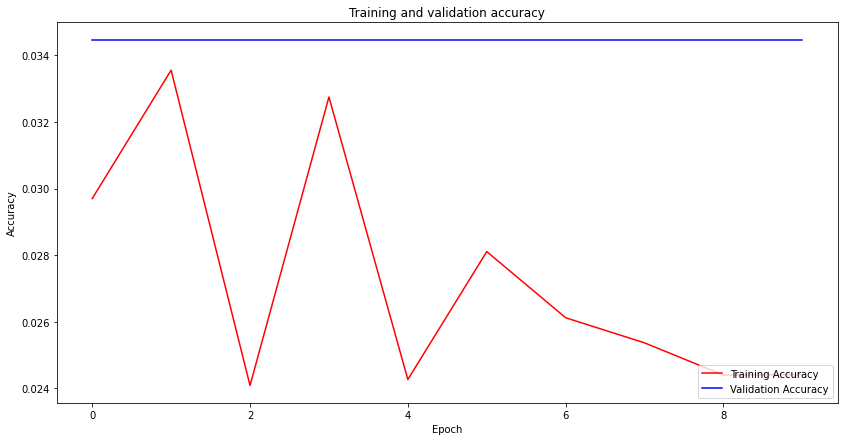

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_4_2l.history.history['accuracy']
val_acc= model_4_2l.history.history['val_accuracy']
loss= model_4_2l.history.history['loss']
val_loss= model_4_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

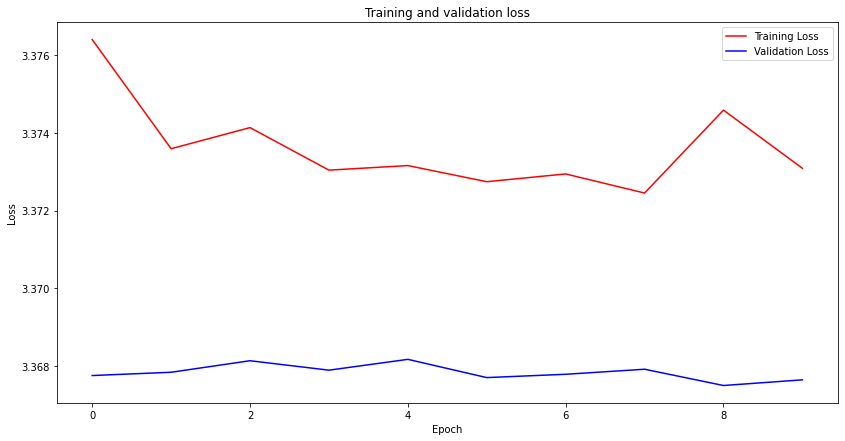

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_4_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 25s 90ms/step - loss: 3.3677 - accuracy: 0.0345
loss : 3.3676528930664062 acc : 0.03447483479976654


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_4_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 25s 90ms/step
              precision    recall  f1-score   support

           A       0.03      1.00      0.07       600
           B       0.00      0.00      0.00       600
           C       0.00      0.00      0.00       600
           D       0.00      0.00      0.00       600
           E       0.00      0.00      0.00       600
           F       0.00      0.00      0.00       600
           G       0.00      0.00      0.00       600
           H       0.00      0.00      0.00       600
           I       0.00      0.00      0.00       602
           J       0.00      0.00      0.00       600
           K       0.00      0.00      0.00       600
           L       0.00      0.00      0.00       600
           M       0.00      0.00      0.00       600
           N       0.00      0.00      0.00       602
           O       0.00      0.00      0.00       600
           P       0.00      0.00      0.00       600
           Q       0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 3600x3600 with 0 Axes>

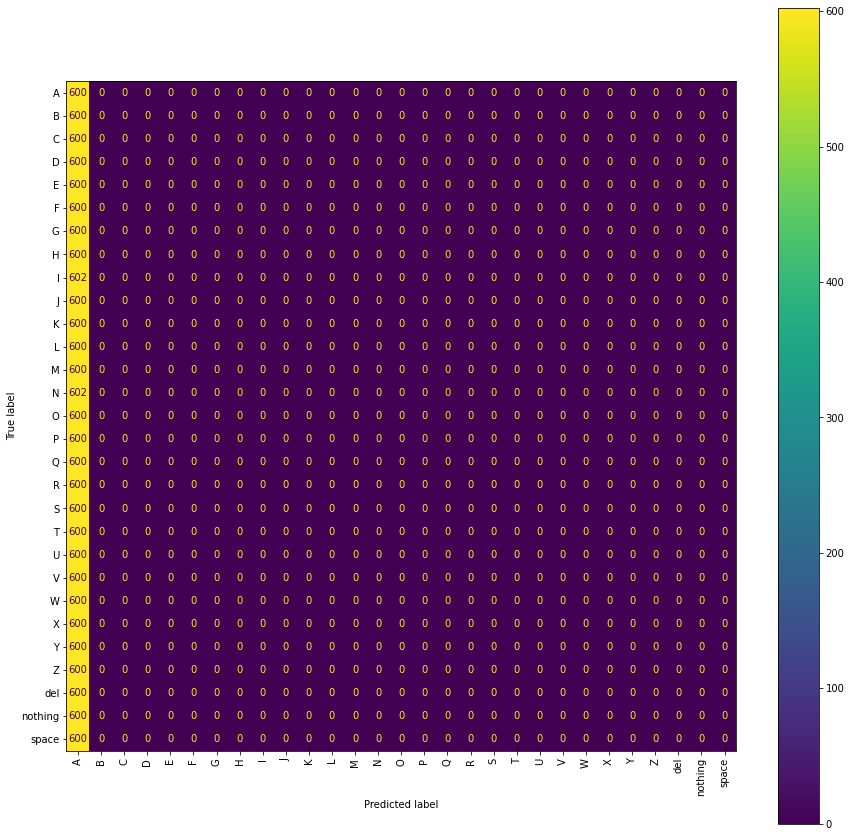

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')

#### **Kernel size - (8,8)**

In [ ]:
# defining the model
model_5_2l = Sequential()

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Conv2D(32, kernel_size=(8,8), input_shape=target_dims))
model_5_2l.add(Activation('relu'))
model_5_2l.add(MaxPooling2D((2, 2)))
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Flatten())
model_5_2l.add(Dropout(0.5))

model_5_2l.add(Dense(128, activation='mish'))

model_5_2l.add(Dense(num_classes, activation='softmax'))

model_5_2l.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 57, 57, 32)        6176      
                                                                 
 activation_14 (Activation)  (None, 57, 57, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 32)        65568     
                                                                 
 activation_15 (Activation)  (None, 21, 21, 32)        0         
                                                      

In [ ]:
# defining the Early Stopping policy
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
# compiling the model
model_5_2l.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model
model_5_2l.fit(train_generator, validation_data = validation_generator, epochs=10,verbose=1)

Epoch 1/10
952/952 [==============================] - 136s 142ms/step - loss: 3.3696 - accuracy: 0.0360 - val_loss: 3.3632 - val_accuracy: 0.0408
Epoch 2/10
952/952 [==============================] - 136s 143ms/step - loss: 3.2849 - accuracy: 0.0591 - val_loss: 3.1400 - val_accuracy: 0.1205
Epoch 3/10
952/952 [==============================] - 138s 145ms/step - loss: 3.0432 - accuracy: 0.1311 - val_loss: 2.7887 - val_accuracy: 0.2009
Epoch 4/10
952/952 [==============================] - 138s 145ms/step - loss: 2.7496 - accuracy: 0.1998 - val_loss: 2.4554 - val_accuracy: 0.2956
Epoch 5/10
952/952 [==============================] - 138s 145ms/step - loss: 2.5091 - accuracy: 0.2578 - val_loss: 2.0995 - val_accuracy: 0.3946
Epoch 6/10
952/952 [==============================] - 138s 145ms/step - loss: 2.2893 - accuracy: 0.3064 - val_loss: 1.8992 - val_accuracy: 0.4360
Epoch 7/10
952/952 [==============================] - 137s 144ms/step - loss: 2.1253 - accuracy: 0.3516 - val_loss: 1.6844 -

In [ ]:
# viewing the model history of loss, accuracy, val_loss, val_accuracy
metrics = pd.DataFrame(model_5_2l.history.history)
print("The model metrics are")
display(metrics)

The model metrics are


loss  accuracy  val_loss  val_accuracy
0  3.369596  0.036018  3.363239      0.040795
1  3.284908  0.059050  3.140038      0.120547
2  3.043189  0.131119  2.788694      0.200873
3  2.749586  0.199757  2.455388      0.295564
4  2.509103  0.257839  2.099489      0.394622
5  2.289314  0.306416  1.899160      0.435992
6  2.125326  0.351643  1.684407      0.501379
7  1.987463  0.388236  1.612884      0.524592
8  1.857278  0.421791  1.441499      0.575040
9  1.737919  0.453623  1.360693      0.599173

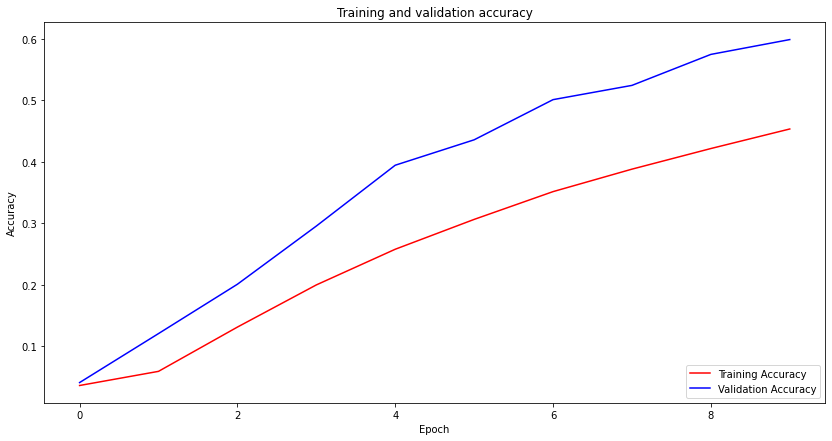

In [ ]:
# plotting training and validation accuracy against number of epochs
acc= model_5_2l.history.history['accuracy']
val_acc= model_5_2l.history.history['val_accuracy']
loss= model_5_2l.history.history['loss']
val_loss= model_5_2l.history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

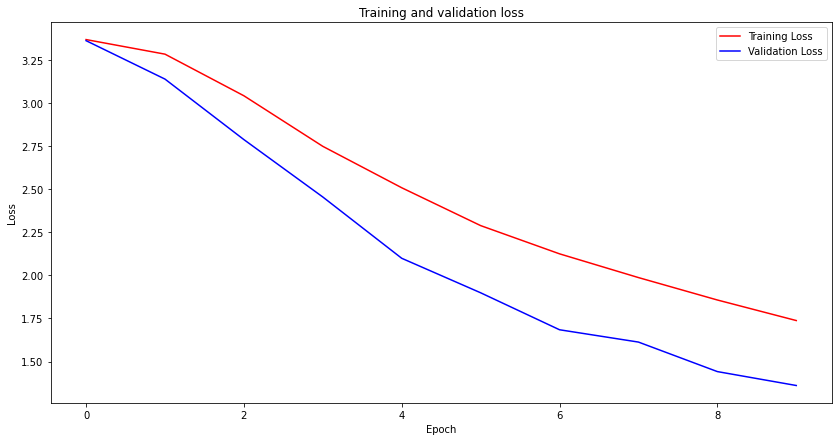

In [ ]:
# plotting training and validation loss against number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
# evaluating the model's performance with test dataset
test_loss, test_acc = model_5_2l.evaluate(test_generator)
print('loss :' ,test_loss, 'acc :' ,test_acc)

272/272 [==============================] - 27s 99ms/step - loss: 1.3557 - accuracy: 0.5983
loss : 1.3556621074676514 acc : 0.5983107089996338


In [ ]:
# Viewing Precision, recall and f1-score for each of the label
# getting the predicted labels
predictions = model_5_2l.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1)

# getting the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

272/272 [==============================] - 26s 95ms/step
              precision    recall  f1-score   support

           A       0.85      0.51      0.63       600
           B       0.60      0.67      0.63       600
           C       0.85      0.92      0.88       600
           D       0.69      0.71      0.70       600
           E       0.65      0.40      0.50       600
           F       0.60      0.85      0.71       600
           G       0.89      0.54      0.68       600
           H       0.65      0.94      0.77       600
           I       0.79      0.55      0.65       602
           J       0.68      0.73      0.70       600
           K       0.47      0.77      0.58       600
           L       0.75      0.75      0.75       600
           M       0.63      0.28      0.38       600
           N       0.59      0.59      0.59       602
           O       0.72      0.63      0.67       600
           P       0.75      0.65      0.70       600
           Q       0.84 

<Figure size 3600x3600 with 0 Axes>

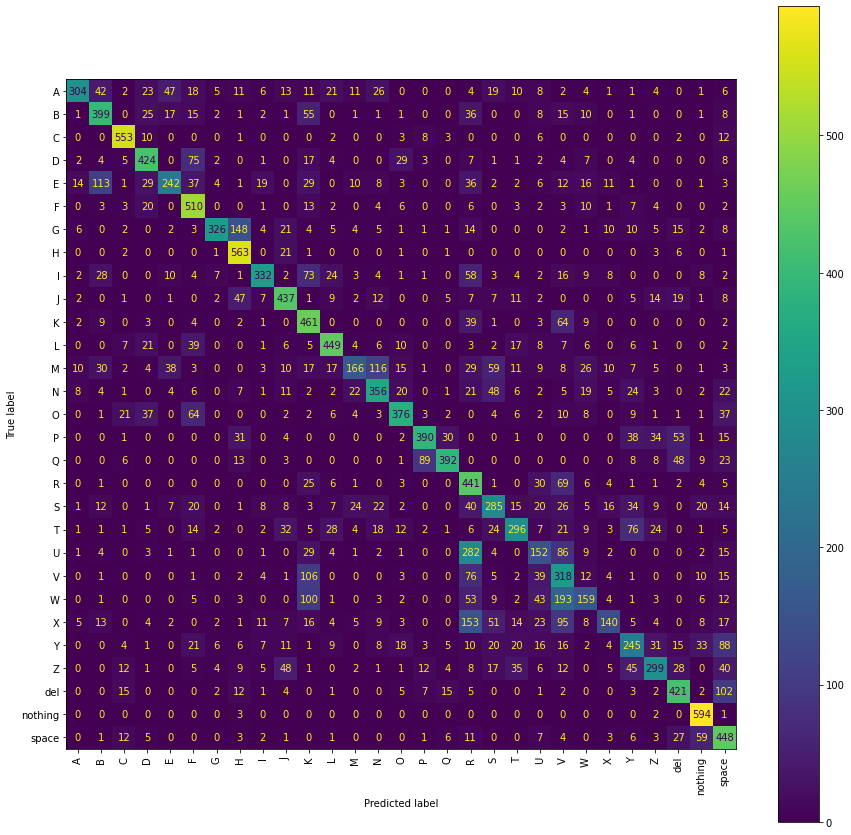

In [ ]:
# plotting the confusion matrix
plt.figure(figsize=(50,50))
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,xticks_rotation='vertical')